In [17]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from skbio.stats.ordination import pcoa
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sb
import plotly as px
import copy
import pickle
import re

In [2]:
def getPairsOfInterest(corr, kpcof, phy_level, direction = "max"):
    corr_tmp = copy.copy(corr)
    num_pairs = 50
    pairs_of_interest_long = [[]]*num_pairs
    correlations = []
    for i in np.arange(num_pairs):
        if direction == "max":
            taxa1 = corr_tmp.max().idxmax()
            taxa2 = corr_tmp.loc[corr_tmp.max().idxmax(), :].idxmax()
        if direction == "min":
            taxa1 = corr_tmp.min().idxmin()
            taxa2 = corr_tmp.loc[corr_tmp.min().idxmin(), :].idxmin()
        pairs_of_interest_long[i] = [taxa1, taxa2]
        correlations.append(corr_tmp.loc[taxa1, taxa2])
        #print(corr_tmp.loc[taxa1, taxa2]) #getting the index of maximally correlated taxa
        corr_tmp.drop([taxa1, taxa2], axis = 0, inplace = True)
        corr_tmp.drop([taxa1,taxa2], axis = 1, inplace = True)
    pairs_of_interest_long = np.array(pairs_of_interest_long)
    correlations = np.array(correlations)
    len(np.unique(np.array(pairs_of_interest_long).flatten())) == num_pairs * 2 #Check all pairs are unique

    not_shigella = []
    for pair in pairs_of_interest_long:
        not_shigella.append(np.sum(kpcof.loc[pair, "Genus2"] == "Escherichia/Shigella") < 2) #Otherwise every pair is shigella, they mutate fast
    len(pairs_of_interest_long[not_shigella]) #pairs that are not shigella
    pairs_of_interest = pairs_of_interest_long[not_shigella]
    correlations = correlations[not_shigella]

    not_na = []
    for pair in pairs_of_interest:
        not_na.append(np.sum(kpcof.loc[pair, phy_level].isna()) == 0)
    pairs_of_interest = pairs_of_interest[not_na]
    correlations = correlations[not_na]
    
    print(correlations)
    return(pairs_of_interest, correlations, corr_tmp)


In [3]:
#Don't include if the phylum is not assigned
def dropUnannotated(qual_vecs, kpcof, phy_level):
    keep = ~kpcof.loc[:, phy_level].isna().values
    kpcof = kpcof.loc[keep, :]
    qual_vecs = qual_vecs.loc[kpcof.index.values, :]
    return(qual_vecs, kpcof)
    
def getOrdination(kpcof, qual_vecs, pairs_of_interest, phy_level = "Family", dist = "euclidean"):
    print("Shape of annotations pre-filtering for NA: " + str(kpcof.shape))
    qual_vecs, kp = dropUnannotated(qual_vecs, kpcof, phy_level)
    #kp = kpcof.loc[:, ["Kingdom", "Phylum", "Class", "Order", "Family"]]
    #kp = kp.dropna("index")
    print("Shape of annotations post-filtering for NA: " + str(kp.shape))

    #Get subset of the data, so long as it has an annotation
    tmp = qual_vecs.iloc[0:1500, :]
    tmp = tmp.loc[[i in kp.index.values for i in tmp.index.values], :]
    print("number of taxa embedding vectors considered: " + str(tmp.shape))

    #make sure that the taxa of interest are in the subset
    for taxa in np.array(pairs_of_interest).flatten():
        tmp.loc[taxa, :] = qual_vecs.loc[taxa, ]
    print("Taxa embedding vectors after including missing pairs of interest: " + str(tmp.shape))

    #get distance matrix
    dist_embed_space = pdist(tmp, metric = dist) #rows are ASVs, columns are embedding dimensions
    dist_embed_mat = squareform(dist_embed_space, force = 'tomatrix')
    dist_embed_df = pd.DataFrame(dist_embed_mat, index = tmp.index.values, columns = tmp.index.values)
    #ordinate
    ord_pcoa = pcoa(dist_embed_mat)
    ord_pcoa.samples.index = tmp.index.values

    print("Number of families NA: " + str(np.sum(kp.Family.isna())))
    return(ord_pcoa, kp, dist_embed_df)

In [4]:
#Make dataframe to color and shape graph parameters
def getColorInfo(kp, phy_level, imp_categories, transparency = 0.2):
    #Makes a mapping from family to index, which will later be used to assign colors
    cmap = np.array([[255, 0, 0, 255], [255, 128, 0, 255],[0, 204, 204, 255], [128, 255, 0, 255], [0, 153, 0, 255],
                         [255, 102, 255, 255] , [51, 153, 255, 255], [0, 0, 255, 255], [153, 51, 255, 255], [153, 0, 153, 255],
                         [204, 204, 0, 255],[255, 51, 153, 255], [153, 0, 76, 255]])
    cmap = cmap[0:(len(np.unique(imp_categories)))]
    cmap = cmap / 255
    num_taxa = len(np.unique(kp.loc[:, phy_level]))
    tmp = tmp = np.tile([0.5, 0.5, 0.5, transparency], (num_taxa, 1))
    cmap = np.vstack([cmap, tmp])


    color_map = pd.Series(np.arange(0, num_taxa))

    cat_by_abundance = kp.loc[:, phy_level].value_counts().index.values
    new_order = np.concatenate([imp_categories, np.array([i for i in cat_by_abundance if i not in imp_categories])])

    color_map.index = new_order
    color_map.head()
    return(color_map, cmap)


def getGraphingParameters(ord_pcoa, kp, pairs_of_interest, phy_level, size = 400, transparency = 0.2):
    kp_plot = kp.loc[ord_pcoa.samples.index.values, :]
    kp_plot.insert(2, "pair_of_interest", [0]*kp_plot.shape[0], True)
    kp_plot.insert(2, "size", [30]*kp_plot.shape[0], True)
    kp_plot.insert(2, "shapes", ['o']*kp_plot.shape[0], True)
    print(ord_pcoa.samples.shape)

    i = 1
    shapes = ['o', '^', 's', 'P', 'D', '*', 'v', '>', 'o', 'p', '<', 'x']
    for taxa_pair in pairs_of_interest:
        #print(taxa_pair)
        kp_plot.loc[taxa_pair, 'pair_of_interest'] = i #ignore the warning, pandas is being dumb
        kp_plot.loc[taxa_pair, 'size'] = size
        kp_plot.loc[taxa_pair, 'shapes'] = shapes[i]
        i = i + 1

    #Make background points grey
    imp_names = [s + '2' for s in  kp_plot.loc[kp_plot.pair_of_interest>0, phy_level]]
    kp_plot.loc[kp_plot.pair_of_interest>0, phy_level] = imp_names
    
    #cmap_tab = matplotlib.cm.get_cmap('Set3')
    #manual color map
    imp_categories = np.unique(imp_names) #classifications that need to be high in the color list
    color_map, cmap = getColorInfo(kp_plot, phy_level, imp_categories, transparency)
    return(kp_plot, color_map, cmap)

def cmap_sns(i):
    return(cmap[i])

In [5]:
def mscatter(x,y, color, ax=None, m=None, **kw):
    global cmap_tab
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y, color = color, **kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [7]:
def doThePlot(ord_pcoa, kp_plot, pairs_of_interest, color_map, save_file = ""):
    data = np.array(ord_pcoa.samples)
    data.shape
    plt.figure(figsize = (ord_pcoa.proportion_explained[0] * 100, ord_pcoa.proportion_explained[1] * 100))
    shapes = np.array(kp_plot.shapes).astype('U')
    scatter = mscatter(data[:, 0], data[:, 1], 
                       color = cmap_sns(color_map[kp_plot.loc[:, phy_level]].values), m = kp_plot.shapes.values, s= kp_plot['size'].values) 

    plt.xlabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[0], 3))+ "%", fontsize = 30)
    plt.ylabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[1], 3))+ "%", fontsize = 30)
    
    labels = [re.sub('2', '', i) for i in color_map.index.values]
    legend_elements = [Line2D([0], [0],  marker = 'o', label = labels[i],
                              markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,12)]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 20)
    kp_plot.loc[pairs_of_interest.flatten(), :]

In [10]:
data_dir = "C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/seqtab_final_filter.07.txt"
#seqtab = pd.read_csv(data_dir, sep = "\t")
#tmp = seqtab.iloc[:, 0:1000]
#tmp.to_csv("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/seqtab_1000_test.csv", sep = "\t")

In [11]:
# We need to find some species that have high correlation
#seqtab_small = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/seqtab_1000_test.csv", sep = "\t")
#seqtab_small = tmp
#corr = seqtab_small.corr('spearman')
#corr[corr == 1] = float("NaN")

In [474]:
pickle.dump(corr, open("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/raw_correlation_matrix_1000.obj", "wb"))

In [12]:
#Read in correlation matrix
corr = pickle.load(open("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/raw_correlation_matrix_1000.obj", "rb"))

In [13]:
#Read in embedding and annotations

qual_vec_file = "C:/Users/ctata/Documents/Lab/Microbiome_ASD_16S/Microbiome_ASD_16S/embeddings/glove_emb_AG_newfilter.07_100.txt"
qual_vecs = pd.read_csv(qual_vec_file, sep = " ", index_col = 0,header = None, dtype = {0:str})

kpcof = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/annotations/kpcof_annotation.txt", sep = " ")
kpcof = kpcof.loc[[i in qual_vecs.index.values for i in kpcof.Seq], :]
qual_vecs = qual_vecs.loc[[i in kpcof.Seq for i in kpcof.index.values], :]
qual_vecs = qual_vecs.loc[kpcof.Seq, ]
kpcof = kpcof.set_index('Seq')

genus_species = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/annotations/genus_species_annotation.txt", sep = " ")
genus_species = genus_species.loc[[i in qual_vecs.index.values for i in genus_species.Seq], :]
print(genus_species.shape)
#np.sum([i == j for (i,j) in zip(genus_species.Seq, kpcof.index.values)])
genus_species = genus_species.set_index('Seq')
genus_species.columns = ["Genus2", "Species"]

print(kpcof.shape)
print(qual_vecs.shape)
print(genus_species.shape)
print(np.sum([i == j for i,j in zip(qual_vecs.index.values, kpcof.index.values)])) #cool

kpcof = pd.concat([kpcof, genus_species], axis = 1)
kpcof.head()
kpcof.loc[kpcof.Genus2.isna(), "Genus2"] = kpcof.Genus[kpcof.Genus2.isna()].values


(26726, 3)
(26726, 6)
(26726, 100)
(26726, 2)
26726


In [14]:
phy_level = "Family"
pairs_of_interest, correlations, corr_tmp = getPairsOfInterest(corr, kpcof, phy_level = phy_level, direction = "max")
pairs_of_interest = pairs_of_interest[0:10]
correlations = correlations[0:10]
kpcof.loc[pairs_of_interest.flatten(), :]

[0.81550636 0.80135729 0.76264477 0.73387229 0.73120537 0.71566777
 0.71427006 0.70524241 0.70511221 0.70447547 0.70376426 0.70084424
 0.70017991 0.6996537 ]


,Kingdom,Phylum,Class,Order,Family,Genus,Genus2,Species
Seq,,,,,,,,
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,NaN,Granulicatella,NaN
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTTAATAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGTTAAACTTGAGTGCAGGAGAGAAAAGTG,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_Incertae_Sedis_XI,Gemella,Gemella,NaN
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTTGTTCTAGAGTGTTGGAGAGGTAAGTG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Oribacterium,Oribacterium,sinus
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCAATGCAAGTCTGAAGTGAAAGGCGTGGGCTCAACCCATGAACTGCTTTGGAAACTGTATAGCTTGAGTGTCGGAGGGGTAAGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoanaerobaculum,Lachnoanaerobaculum,NaN
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTTAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus,NaN
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTTGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus,NaN
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus,NaN
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTA,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria,Neisseria,NaN
TACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGCCTTTCAAGTCAGGGGTGAAAACCTGCGGCTCAACCGCAGGCCTGCCTTTGAAACTGATAGGCTGGAGTACCGGAGAGGTGGACG,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia,Leptotrichia,NaN


In [15]:
ord_pcoa, kp, dist_embed_df = getOrdination(kpcof, qual_vecs, pairs_of_interest, phy_level, dist = "cosine") 
kp_plot, color_map, cmap = getGraphingParameters(ord_pcoa, kp, pairs_of_interest, phy_level)

Shape of annotations pre-filtering for NA: (26726, 8)
Shape of annotations post-filtering for NA: (23966, 8)
number of taxa embedding vectors considered: (1500, 100)
Taxa embedding vectors after including missing pairs of interest: (1500, 100)
Number of families NA: 0
(1500, 1500)


c:\users\ctata\miniconda3\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:152: RuntimeWarning:

The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.930063148566116 and the largest is 103.4997014462873.



In [384]:
ord_pcoa.proportion_explained[0:2]

PC1    0.202856
PC2    0.137399
dtype: float64

In [24]:
def doThePlot(ord_pcoa, kp_plot, pairs_of_interest, color_map, save_file = ""):
    data = np.array(ord_pcoa.samples)
    data.shape
    fig = plt.figure(figsize = (ord_pcoa.proportion_explained[0] * 100, ord_pcoa.proportion_explained[1] * 100))
    ax = plt.subplot(111)
    shapes = np.array(kp_plot.shapes).astype('U')
    scatter = mscatter(data[:, 0], data[:, 1], ax = ax, 
                       color = cmap_sns(color_map[kp_plot.loc[:, phy_level]].values), m = kp_plot.shapes.values, s= kp_plot['size'].values) 

    plt.xlabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[0], 3))+ "%", fontsize = 30)
    plt.ylabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[1], 3))+ "%", fontsize = 30)
    
    labels = [re.sub('2', '', i) for i in color_map.index.values]
    legend_elements = [Line2D([0], [0],  marker = 'o', label = labels[i],
                              markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,12)]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 20)
    kp_plot.loc[pairs_of_interest.flatten(), :]

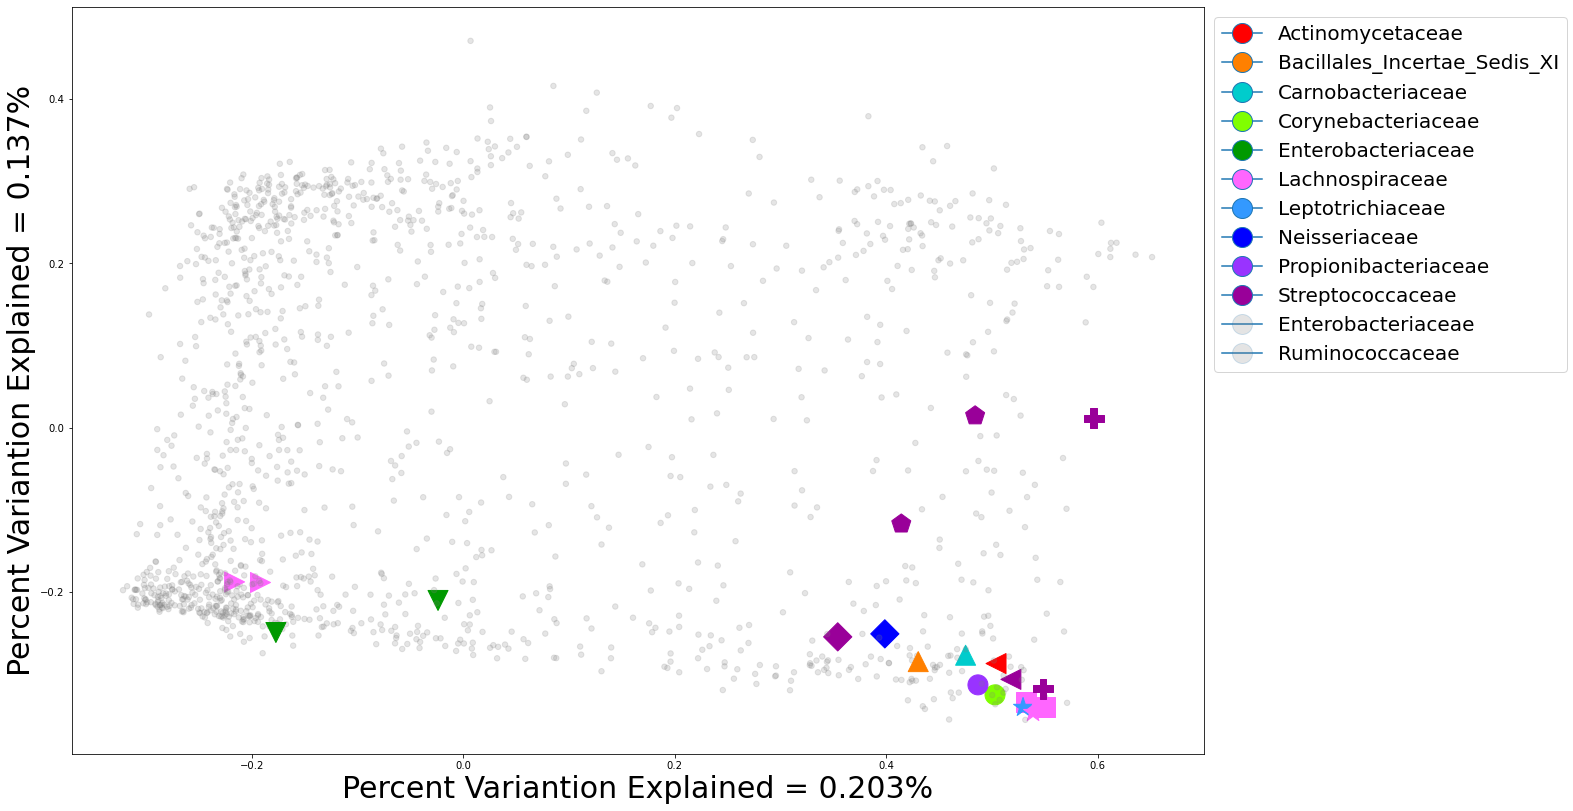

In [27]:
doThePlot(ord_pcoa, kp_plot, pairs_of_interest, color_map)
kp_plot.loc[pairs_of_interest.flatten(), :]
plt.savefig('../figures/phylogeny_cooccurrence_pcoa.svg', bbox_inches = "tight")

In [28]:
pairs_of_interest_min, correlations_min, corr_tmp = getPairsOfInterest(corr, kpcof, direction = "min", phy_level = phy_level)
pairs_of_interest_min = pairs_of_interest_min[0:10]
correlations_min = correlations_min[0:10]
kpcof.loc[pairs_of_interest_min.flatten(), :]

TypeError: getPairsOfInterest() missing 1 required positional argument: 'phy_level'

In [470]:
pairs_of_interest_min, correlations_min, corr_tmp = getPairsOfInterest(corr_tmp, kpcof, direction = "min")
pairs_of_interest_min = pairs_of_interest_min[0:10]
correlations_min = correlations_min[0:10]
#kpcof.loc[pairs_of_interest_min.flatten(), :]

[-0.09817792 -0.09676846 -0.09578398 -0.09447751 -0.09434627 -0.09408908
 -0.09385626 -0.09384709 -0.093846   -0.0927086  -0.0922062  -0.09156942
 -0.09131763 -0.09130964 -0.09111728 -0.08979665 -0.08913064 -0.08878122
 -0.08762535 -0.0875475  -0.08722535 -0.08592586 -0.08574561 -0.08475051
 -0.08467259 -0.08305271 -0.08283181 -0.08268011 -0.08172245 -0.08129521
 -0.08119642 -0.0810291  -0.08043387 -0.07934819 -0.0789433  -0.07827924
 -0.07769356 -0.07709697 -0.07707075 -0.0767012  -0.07653518 -0.07628684
 -0.07606373 -0.07526468 -0.07486913 -0.07392559 -0.07382591 -0.07345838
 -0.07248699]


In [476]:
#Of these, which are close in embedding space?
ord_pcoa, kp, dist_embed_df = getOrdination(kpcof, qual_vecs, pairs_of_interest_min)

Shape of annotations pre-filtering for NA: (26726, 5)
Shape of annotations post-filtering for NA: (23966, 5)
number of taxa embedding vectors considered: (1306, 100)
Taxa embedding vectors after including missing pairs of interest: (1306, 100)
Number of families NA: 0


In [472]:
kp_plot, color_map, cmap = getGraphingParameters(ord_pcoa, kp, pairs_of_interest_min, phy_level, size = 200, transparency = 0.1)

(1306, 1306)
84


,Kingdom,Phylum,shapes,size,pair_of_interest,Class,Order,Family
Seq,,,,,,,,
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGCTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCG,Bacteria,Bacteroidetes,^,200,1,Bacteroidia,Bacteroidales,Bacteroidaceae2
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGAAAAACTTGAGTGCAGAAGAGGAAAGTG,Bacteria,Firmicutes,^,200,1,Bacilli,Bacillales,Staphylococcaceae2
TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCATAGCTGGAGTACAGGAGAGGCAGGCG,Bacteria,Firmicutes,s,200,2,Clostridia,Clostridiales,Lachnospiraceae2
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGTGTGTTGTGAAATGTAGACGCTCAACGTCTGACTTGCAGCGCATACTGGTTTCCTTGAGTACGCACAACGTTGGCG,Bacteria,Bacteroidetes,s,200,2,Bacteroidia,Bacteroidales,Prevotellaceae2
TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGTATCAAGTCTGATGTGAAAGGCAGGGGCTTAACCCCTGGACTGCATTGGAAACTGGTATGCTTGAGTGCCGGAGGGGTAAGCG,Bacteria,Firmicutes,P,200,3,Clostridia,Clostridiales,Lachnospiraceae2
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTAAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATTGCCTTTTAGACTGCATCGCTTGAATCATGGAGAGGTCAGTG,Bacteria,Proteobacteria,P,200,3,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae2
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGCAGGCGGTTTGTTAAGTTTAAGGTGAAAGCGTGGGGCTTAACCCCATATAGCCTTAGAAACTGACAGACTAGAGTACAGGAGAGGGCAATGG,Bacteria,Firmicutes,D,200,4,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae2
TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTTGTCGCGTCTGCTGTGAAAATCCGGGGCTCAACCCCGGACTTGCAGTGGGTACGGGCAGACTAGAGTGTGGTAGGGGAGACTG,Bacteria,Actinobacteria,D,200,4,Actinobacteria,Actinomycetales,Intrasporangiaceae2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGTCGGCAAGTCAGATGTGAAATCCACGGGCTTAACTCGTGAACTGCATTTGAAACTGTTGATCTTGAGTATCGGAGAGGCAATCG,Bacteria,Firmicutes,*,200,5,Clostridia,Clostridiales,Ruminococcaceae2


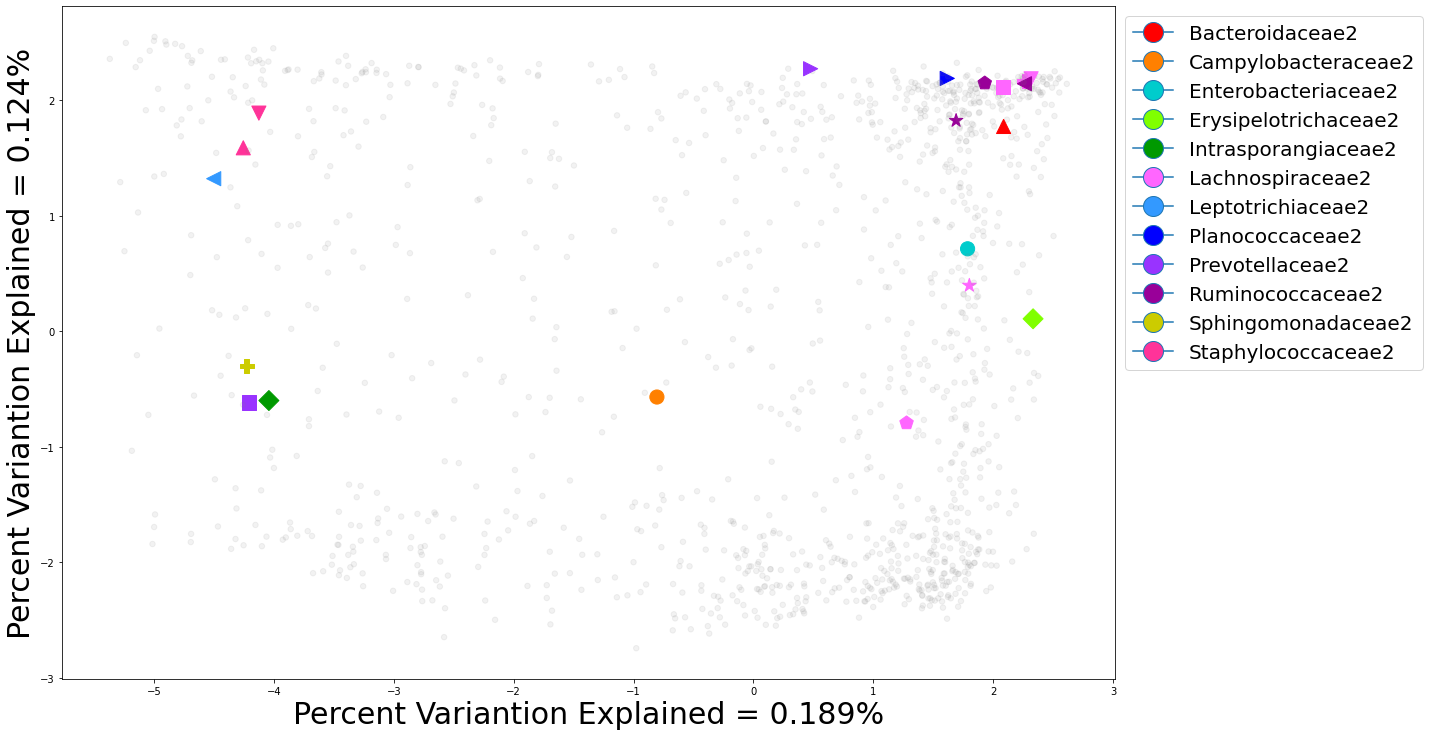

In [473]:
doThePlot(ord_pcoa, kp_plot, pairs_of_interest_min, color_map)
kp_plot.loc[pairs_of_interest_min.flatten(), :]

In [474]:
kpcof.loc[pairs_of_interest_min.flatten(), :]

,Kingdom,Phylum,Class,Order,Family,Genus,Genus2,Species
Seq,,,,,,,,
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGCTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCG,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides,NaN
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCGCGTAGGCGGTTTTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGAAAAACTTGAGTGCAGAAGAGGAAAGTG,Bacteria,Firmicutes,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus,NaN
TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGCAGTGCAAGTCAGATGTGAAAGGCCGGGGCTCAACCCCGGAGCTGCATTTGAAACTGCATAGCTGGAGTACAGGAGAGGCAGGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,NaN,NaN,NaN
TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGATTAAGTGTGTTGTGAAATGTAGACGCTCAACGTCTGACTTGCAGCGCATACTGGTTTCCTTGAGTACGCACAACGTTGGCG,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,Prevotella,NaN
TACGTAGGGGGCGAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGTATCAAGTCTGATGTGAAAGGCAGGGGCTTAACCCCTGGACTGCATTGGAAACTGGTATGCTTGAGTGCCGGAGGGGTAAGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,Blautia,NaN
TACGGAGGGAGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTAAGAGGTGAAAGCCCAGAGCTCAACTCTGGAATTGCCTTTTAGACTGCATCGCTTGAATCATGGAGAGGTCAGTG,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas,Sphingomonas,NaN
TACGTAGGTGGCGAGCGTTATCCGGAATTATTGGGCGTAAAGGGTGCGCAGGCGGTTTGTTAAGTTTAAGGTGAAAGCGTGGGGCTTAACCCCATATAGCCTTAGAAACTGACAGACTAGAGTACAGGAGAGGGCAATGG,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Holdemania,Holdemania,filiformis
TACGTAGGGTGCGAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTTGTAGGCGGTTTGTCGCGTCTGCTGTGAAAATCCGGGGCTCAACCCCGGACTTGCAGTGGGTACGGGCAGACTAGAGTGTGGTAGGGGAGACTG,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Intrasporangiaceae,Janibacter,Janibacter,NaN
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGTCGGCAAGTCAGATGTGAAATCCACGGGCTTAACTCGTGAACTGCATTTGAAACTGTTGATCTTGAGTATCGGAGAGGCAATCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Oscillibacter,Oscillibacter,NaN


# We're moving on to comp. based methods
### Sort ASVs by their proximity in embedding space, and look to see if proximity is caused by direct or indirect co-occurrence

In [10]:
pairs_of_interest_min, correlations_min, corr_tmp = getPairsOfInterest(corr, kpcof, direction = "min")
pairs_of_interest_min = pairs_of_interest_min[0:10]
correlations_min = correlations_min[0:10]
ord_pcoa, kp, dist_embed_df = getOrdination(kpcof, qual_vecs, pairs_of_interest_min)

[-0.43206912 -0.41355781 -0.40976212 -0.37799786 -0.36950828 -0.36036524
 -0.3553036  -0.34517783 -0.34070135 -0.32762418 -0.32265454 -0.32039832
 -0.3157785  -0.30564869 -0.30086383 -0.29974531 -0.29113243 -0.28815663
 -0.28226746 -0.28150831 -0.27077045 -0.26671497 -0.26161341 -0.25859515
 -0.25359074 -0.24824634 -0.24631489 -0.24505397 -0.2421459  -0.24129261
 -0.23621633 -0.23530317 -0.2351231  -0.23325648 -0.22684545 -0.22330081
 -0.22185594 -0.22171431 -0.22155943 -0.21787736 -0.21129426 -0.21069944
 -0.20754011 -0.20728633 -0.2059341  -0.20563184 -0.20553867 -0.20328296
 -0.20101757 -0.20091494]
Shape of annotations pre-filtering for NA: (26726, 5)
Shape of annotations post-filtering for NA: (23966, 5)
number of taxa embedding vectors considered: (1306, 100)
Taxa embedding vectors after including missing pairs of interest: (1306, 100)
Number of families NA: 0


(array([[  2.,   6.,   8., ..., 194.,   0.,   0.],
        [  2.,   7.,   7., ..., 247.,   0.,   0.],
        [  4.,   5.,   8., ..., 296.,  72.,   0.],
        ...,
        [  2.,   1.,   1., ..., 314., 144.,  44.],
        [  1.,   0.,   2., ..., 525., 143.,  70.],
        [  1.,   2.,   0., ..., 294., 152.,  55.]]),
 array([ 0.        ,  1.01437848,  2.02875696,  3.04313544,  4.05751392,
         5.0718924 ,  6.08627088,  7.10064936,  8.11502784,  9.12940631,
        10.14378479]),
 <a list of 1306 Lists of Patches objects>)

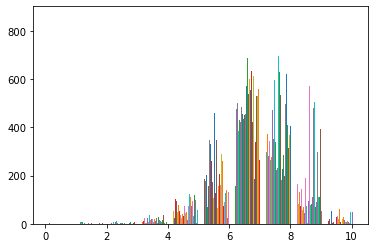

In [479]:
#Find closest in embedding space. Who do we care about most?
plt.hist(dist_embed_df)

In [11]:
tmp = dist_embed_df[dist_embed_df < 1]
tmp = tmp.replace({0:np.nan})
i = 0
taxa1 = tmp.idxmin()[i]
taxa2 = tmp.idxmin().index.values[i]
print(tmp.loc[taxa1, taxa2])
print(corr.loc[taxa1, taxa2])

0.6038441953848692
0.135080644191546


In [12]:
#change i to get pairs of taxa that are closest in embedding space
dists_sort = np.sort(np.array(tmp).ravel())[0:20]
i = 4
inx = np.where(tmp == dists_sort[i])
taxa1 = tmp.index.values[inx[0][0]]
taxa2 = tmp.index.values[inx[0][1]]
print(tmp.loc[taxa1, taxa2])
print(taxa1)
print(taxa2)
print(corr.loc[taxa1, taxa2])
kpcof.loc[[taxa1, taxa2], ]

0.6189910803347656
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCG
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCG
0.5565752318096681


,Kingdom,Phylum,Class,Order,Family,Genus,Genus2,Species
Seq,,,,,,,,
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Faecalibacterium,Faecalibacterium,prausnitzii
TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGTACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGGGGTAAGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Roseburia,NaN,NaN


### TSNE

In [29]:
#Share infor between genus annotations
kpcof.loc[kpcof.Genus2.isna(), "Genus2"] = kpcof.Genus[kpcof.Genus2.isna()]

In [30]:
kp = kpcof.loc[:, ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus2"]]
print("Shape of annotations pre-filtering for NA: " + str(kp.shape))
kp = kp.dropna("index")
print("Shape of annotations post-filtering for NA: " + str(kp.shape))
phy_level = "Genus2"


Shape of annotations pre-filtering for NA: (26726, 6)
Shape of annotations post-filtering for NA: (19864, 6)


In [31]:
i = 5000
data = qual_vecs.iloc[0:i, :]
kp = kp.loc[[i in data.index.values for i in kp.index.values], :]
data = data.loc[kp.index.values, :]
print(np.sum([i == j for i, j in zip(data.index.values, kp.index.values)])) #check

genus_color = ["Escherichia/Shigella", "Bacteroides", "Faecalibacterium", "Roseburia", "Staphylococcus", "Ruminococcus",
              "Prevotella", "Pseudomonas", "Akkermansia", "Blautia", "Neisseria", 'Streptococcus', 'Campylobacter', "Bifidobacterium", 
              "Clostridium"] #everything else will be grey

color_map, cmap = getColorInfo(kp = kp, phy_level = "Genus2", imp_categories = genus_color, transparency = 0.3)


3545


In [32]:
tsne = TSNE(n_components=2).fit_transform(data)
tsne.shape

(3545, 2)

In [33]:
#get distance matrix
dist_embed_space = pdist(data, metric = 'euclidean') #rows are ASVs, columns are embedding dimensions
dist_embed_mat = squareform(dist_embed_space, force = 'tomatrix')
dist_embed_df = pd.DataFrame(dist_embed_mat, index = data.index.values, columns = data.index.values)
#ordinate
ord_pcoa = pcoa(dist_embed_mat)
ord_pcoa.samples.index = data.index.values

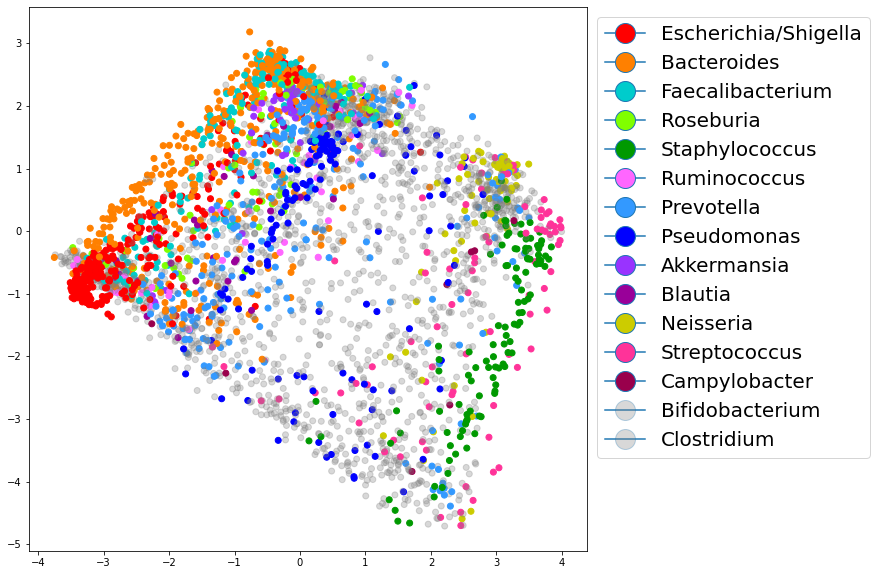

In [34]:
plt.figure(figsize=(10,10))
scatter = mscatter(ord_pcoa.samples.iloc[:, 0], ord_pcoa.samples.iloc[:, 1], 
                   color = cmap_sns(color_map[kp.loc[:, phy_level]].values)) 
legend_elements = [Line2D([0], [0],  marker = 'o', label = color_map.index.values[i],
                          markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,len(genus_color))]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 20)

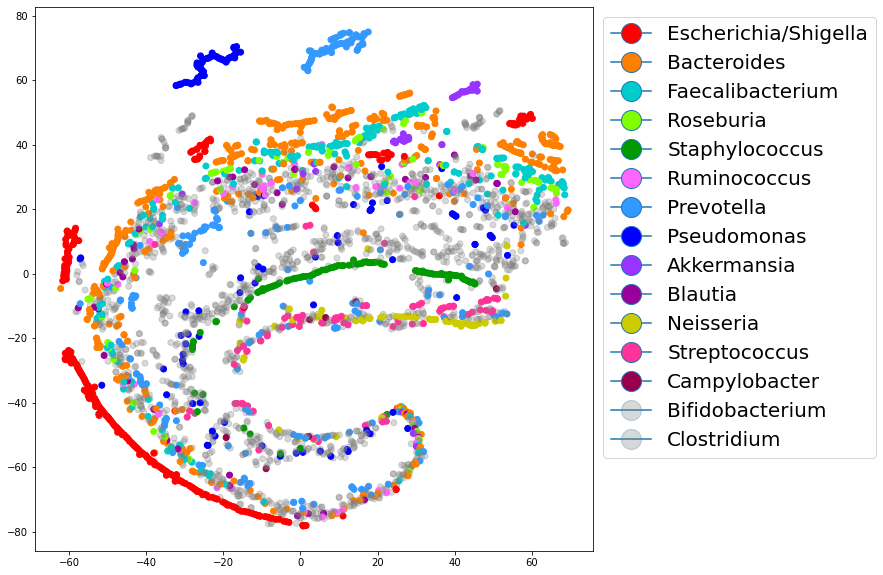

In [36]:
plt.figure(figsize=(10,10))
scatter = mscatter(tsne[:, 0], tsne[:, 1], 
                   color = cmap_sns(color_map[kp.loc[:, phy_level]].values)) 

#plt.xlabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[0], 3))+ "%", fontsize = 30)
#plt.ylabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[1], 3))+ "%", fontsize = 30)
legend_elements = [Line2D([0], [0],  marker = 'o', label = color_map.index.values[i],
                          markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,len(genus_color))]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 20)
plt.savefig('../figures/phylogeny_tsne_embedding.svg', bbox_inches = "tight")

In [348]:
def getColorInfoManual(kp, phy_level, imp_categories, transparency = 0.2):
    #Makes a mapping from family to index, which will later be used to assign colors
    cmap = np.array([[0, 153, 0, 255],
                         [204, 204, 0, 255],[255, 51, 153, 255]])
    cmap = cmap[0:(len(np.unique(imp_categories)))]
    cmap = cmap / 255
    num_taxa = len(np.unique(kp.loc[:, phy_level]))
    tmp = tmp = np.tile([0.5, 0.5, 0.5, transparency], (num_taxa, 1))
    cmap = np.vstack([cmap, tmp])


    color_map = pd.Series(np.arange(0, num_taxa))

    cat_by_abundance = kp.loc[:, phy_level].value_counts().index.values
    new_order = np.concatenate([imp_categories, np.array([i for i in cat_by_abundance if i not in imp_categories])])

    color_map.index = new_order
    color_map.head()
    return(color_map, cmap)


kp = kpcof.loc[:, ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus2"]]
print("Shape of annotations pre-filtering for NA: " + str(kp.shape))
kp = kp.dropna("index")
print("Shape of annotations post-filtering for NA: " + str(kp.shape))
phy_level = "Genus2"



#are these 3 functioning synergistically (actually co-occurring) or are they fucking the same bug?
taxa1 = kpcof.index.values[kpcof.Genus2 == "Staphylococcus"]
taxa2 = kpcof.index.values[kpcof.Genus2 == "Neisseria"]
taxa3 = kpcof.index.values[kpcof.Genus2 == "Streptococcus"]
#taxa = np.append(taxa1, taxa2, taxa3)
taxa_color = np.append(taxa1, taxa2)
taxa_color = np.append(taxa_color, taxa3)


Shape of annotations pre-filtering for NA: (26726, 6)
Shape of annotations post-filtering for NA: (19864, 6)


In [329]:
#WEIRD SATURATION THING GOING ON
seqtab_small = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/seqtab_1000_test.csv", sep = "\t", index_col = 0)
seqtab = seqtab_small.T
taxa = list(set(seqtab.index.values).intersection(kp.index.values))
kp = kp.loc[taxa, :]
seqtab = seqtab.loc[taxa, :]
np.sum([i == j for i, j in zip(seqtab.index.values, kp.index.values)])

genus_color = ["Staphylococcus", "Neisseria", 'Streptococcus'] #everything else will be grey
color_map, cmap = getColorInfoManual(kp = kp, phy_level = "Genus2", imp_categories = genus_color, transparency = 0.3)

tsne = TSNE(n_components=2).fit_transform(seqtab)
tsne.shape

plt.figure(figsize=(10,10))
scatter = mscatter(tsne[:, 0], tsne[:, 1], 
                   color = cmap_sns(color_map[kp.loc[:, phy_level]].values)) 
legend_elements = [Line2D([0], [0],  marker = 'o', label = color_map.index.values[i],
                          markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,len(genus_color))]

plt.legend(handles=legend_elements, bbox_to_anchor=(1.45, 1), fontsize = 20)

721


c:\users\ctata\miniconda3\lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:152: RuntimeWarning:

The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.8058728301300093 and the largest is 59.30203915729269.



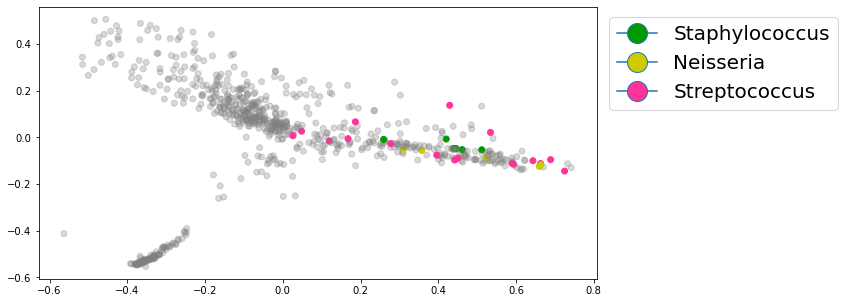

In [351]:

#From a pcoa on correlation, it appears the genera are functioning synergistically
#Read in correlation matrix
corr = pickle.load(open("C:/Users/ctata/Documents/Lab/quality_vectors_git/data/AG_new/filter_.07/raw_correlation_matrix_1000.obj", "rb"))
kp = kp.loc[[i in corr.index.values for i in kp.index.values], :]
corr = corr.loc[kp.index.values, kp.index.values]
corr = 1 - corr
print(np.sum([i == j for i, j in zip(corr.index.values, kp.index.values)])) #check

genus_color = ["Staphylococcus", "Neisseria", 'Streptococcus'] #everything else will be grey
color_map, cmap = getColorInfoManual(kp = kp, phy_level = "Genus2", imp_categories = genus_color, transparency = 0.3)

corr[corr.isna()] = 0
#ordinate
ord_pcoa = pcoa(corr)
ord_pcoa.samples.index = corr.index.values

plt.figure(figsize=(10,5))
scatter = mscatter(ord_pcoa.samples.iloc[:, 0], ord_pcoa.samples.iloc[:, 1], 
                   color = cmap_sns(color_map[kp.loc[:, phy_level]].values)) 
legend_elements = [Line2D([0], [0],  marker = 'o', label = color_map.index.values[i],
                          markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,len(genus_color))]

plt.legend(handles=legend_elements, bbox_to_anchor=(1.45, 1), fontsize = 20)


In [303]:
ord_pcoa.samples.shape

(721, 721)

In [290]:
corr.shape

(1000, 1000)

In [294]:
taxa = taxa[[i in corr.index.values for i in taxa]]
print(len(taxa))
np.mean(np.mean(corr.loc[taxa, taxa]))

28


0.23652319255533394

337


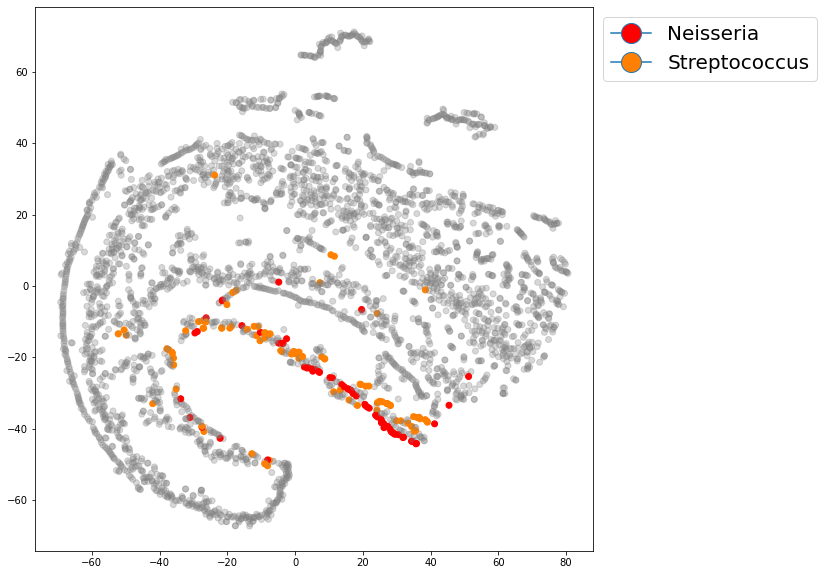

In [177]:
genera =np.unique(kp.loc[:, phy_level].values)
genus_color = np.array(['Neisseria','Streptococcus'])
i = 34
genus_color = np.append(genus_color, genera[(i*10):(i*10+10)])
color_map, cmap = getColorInfo(kp = kp, phy_level = "Genus2", imp_categories = genus_color, transparency = 0.3)

plt.figure(figsize=(10,10))
scatter = mscatter(tsne[:, 0], tsne[:, 1], 
                   color = cmap_sns(color_map[kp.loc[:, phy_level]].values)) 

#plt.xlabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[0], 3))+ "%", fontsize = 30)
#plt.ylabel("Percent Variantion Explained = " + str(round(ord_pcoa.proportion_explained[1], 3))+ "%", fontsize = 30)
legend_elements = [Line2D([0], [0],  marker = 'o', label = color_map.index.values[i],
                          markerfacecolor = cmap_sns(color_map[i]), markersize=20) for i in np.arange(0,len(genus_color))]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 20)


In [31]:
tsne = TSNE(n_components=2).fit_transform(data)

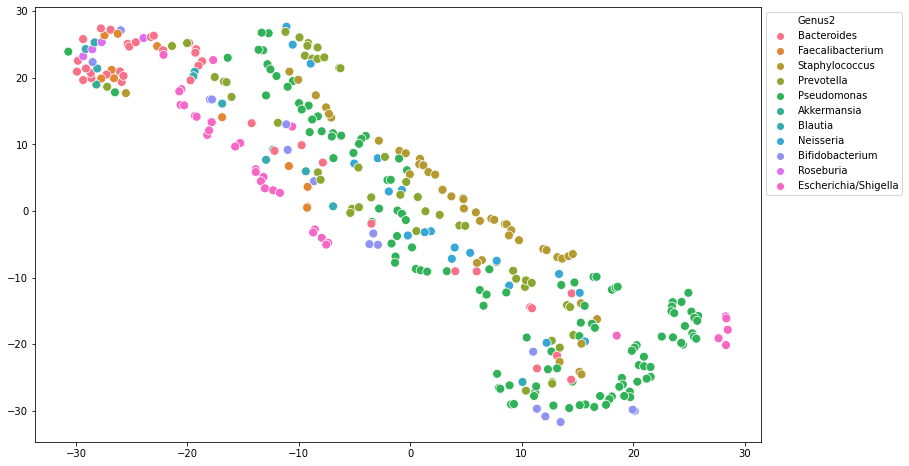

In [32]:
import seaborn as sns
plt.figure(figsize=(13,8))
g = sns.scatterplot(tsne[:, 0], tsne[:, 1], data = kpcof_tsne, hue = "Genus2", s= 80)
plt.legend(bbox_to_anchor=(1, 1), loc=2)



In [650]:
def mscatter3D(x,y,z, c, ax=None, m=None, **kw):
    global cmap_tab
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter3D(x,y,z, c = c, cmap = cmap_tab, **kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

plt.figure(figsize = (20, 10))
ax = plt.axes(projection='3d')
scatter = mscatter3D(data[:, 0], data[:, 1],data[:, 2], 
                   c = color_index.loc[kp_plot.loc[:, phy_level].values], s= kp_plot['size'].values, ax=ax, 
                  m = shape_map) 


legend_elements = [Line2D([0], [0],  marker = 'o', label = color_index.index.values[i],
                          markerfacecolor = cmap_tab(color_index[i]), markersize=20) for i in np.arange(0,len(color_index))]

ax.legend(handles=legend_elements, bbox_to_anchor=(.95, .85), fontsize = 20)

#add variance explained to the axes

[0.81550636 0.80135729 0.76264477 0.73387229 0.73120537 0.71566777
 0.71427006]


,Kingdom,Phylum,Class,Order,Family,Genus
Seq,,,,,,
TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTCCTTAAGTCTGATGTGAAAGCCCCCGGCTCAACCGGGGAGGGTCATTGGAAACTGGGGAACTTGAGTGCAGAAGAGGAGAGTG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,NaN
TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGTGGTTTAATAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGTTAAACTTGAGTGCAGGAGAGAAAAGTG,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillales_Incertae_Sedis_XI,Gemella
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGAATGGCAAGTCTGAAGTGAAATACCCGGGCTCAACCTGGGAACTGCTTTGGAAACTGTTGTTCTAGAGTGTTGGAGAGGTAAGTG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Oribacterium
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGCAATGCAAGTCTGAAGTGAAAGGCGTGGGCTCAACCCATGAACTGCTTTGGAAACTGTATAGCTTGAGTGTCGGAGGGGTAAGCG,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnoanaerobaculum
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTTAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTTGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGG,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus
TACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGCGCAGACGGTTACTTAAGCAGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCGTTCTGAACTGGGTGACTAGAGTGTGTCAGAGGGAGGTA,Bacteria,Proteobacteria,Betaproteobacteria,Neisseriales,Neisseriaceae,Neisseria
TACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGCCTTTCAAGTCAGGGGTGAAAACCTGCGGCTCAACCGCAGGCCTGCCTTTGAAACTGATAGGCTGGAGTACCGGAGAGGTGGACG,Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Leptotrichiaceae,Leptotrichia


ValueError: Unrecognized marker style array(['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', '^', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', '^', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o'], dtype='<U1')

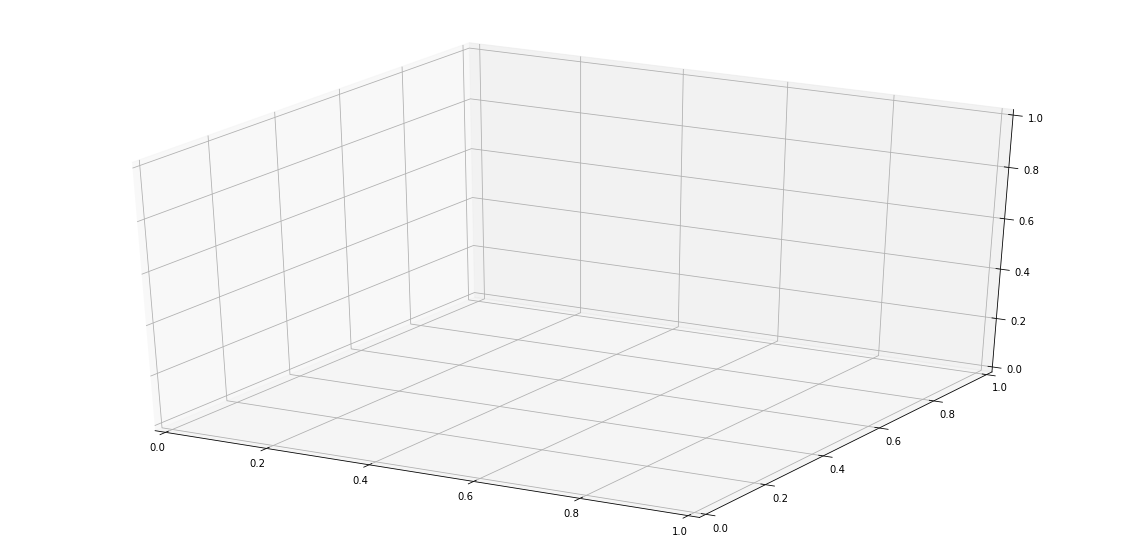

In [319]:


plt.figure(figsize = (20, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(data[:, 0], data[:, 1], data[:, 2], cmap = 'tab20b',
             c = color_index.loc[kp_plot.Phylum.values], s = 70, marker = shape_map)
legend_elements = [Line2D([0], [0],  color='w', label=color_index.index.values[i],
                          markerfacecolor= cmap(color_index[i]), markersize=15) for i in np.arange(0,27)]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, .85))

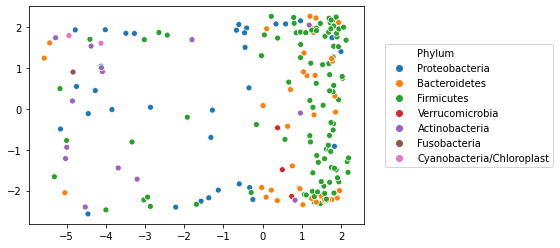

In [136]:
#ax = plt.axes()
sb.scatterplot(data[:, 0], data[:, 1], kp_plot.Phylum)
plt.legend(bbox_to_anchor=(1.05, .85))

In [90]:
df = pd.DataFrame(np.zeros((len(names), len(names))))
df.index = names
df.columns = names
df.head()

,Proteobacteria,Bacteroidetes,Firmicutes,Verrucomicrobia,Actinobacteria,Fusobacteria,nan,Cyanobacteria/Chloroplast,Euryarchaeota,SR1,...,Deferribacteres,Thaumarchaeota,Chloroflexi,Planctomycetes,Gemmatimonadetes,Chlamydiae,Nitrospirae,candidate_division_WPS-1,Armatimonadetes,BRC1
Proteobacteria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bacteroidetes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Firmicutes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Verrucomicrobia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Actinobacteria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
from collections import Counter
#grouped = qual_vecs.groupby('Phylum')
names = [i for i in Counter(qual_vecs.Phylum).keys()]
used_names = []

for phylum1 in names:
    used_names.append(phylum1)
    for phylum2 in names:
        print(str(phylum1) + str(phylum2))
        tmp1 = qual_vecs.loc[qual_vecs.Phylum == phylum1]
        tmp2 = qual_vecs.loc[qual_vecs.Phylum == phylum2]
        tmp1 = tmp1.drop(["Phylum", "Class"], axis = 1)
        tmp2 = tmp2.drop(["Phylum", "Class"], axis = 1)
        df.loc[phylum1, phylum2] = np.mean(cdist(tmp1, tmp2, metric = 'cosine'))

ProteobacteriaProteobacteria
ProteobacteriaBacteroidetes
ProteobacteriaFirmicutes
ProteobacteriaVerrucomicrobia
ProteobacteriaActinobacteria
ProteobacteriaFusobacteria
Proteobacterianan
ProteobacteriaCyanobacteria/Chloroplast


c:\users\ctata\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\ctata\miniconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ProteobacteriaEuryarchaeota
ProteobacteriaSR1
ProteobacteriaLentisphaerae
ProteobacteriaSynergistetes
ProteobacteriaDeinococcus-Thermus
ProteobacteriaCandidatus_Saccharibacteria
ProteobacteriaElusimicrobia
ProteobacteriaSpirochaetes
ProteobacteriaTenericutes
ProteobacteriaAcidobacteria
ProteobacteriaDeferribacteres
ProteobacteriaThaumarchaeota
ProteobacteriaChloroflexi
ProteobacteriaPlanctomycetes
ProteobacteriaGemmatimonadetes
ProteobacteriaChlamydiae
ProteobacteriaNitrospirae
Proteobacteriacandidate_division_WPS-1
ProteobacteriaArmatimonadetes
ProteobacteriaBRC1
BacteroidetesProteobacteria
BacteroidetesBacteroidetes
BacteroidetesFirmicutes
BacteroidetesVerrucomicrobia
BacteroidetesActinobacteria
BacteroidetesFusobacteria
Bacteroidetesnan
BacteroidetesCyanobacteria/Chloroplast
BacteroidetesEuryarchaeota
BacteroidetesSR1
BacteroidetesLentisphaerae
BacteroidetesSynergistetes
BacteroidetesDeinococcus-Thermus
BacteroidetesCandidatus_Saccharibacteria
BacteroidetesElusimicrobia
Bacteroidete

Deinococcus-ThermusBacteroidetes
Deinococcus-ThermusFirmicutes
Deinococcus-ThermusVerrucomicrobia
Deinococcus-ThermusActinobacteria
Deinococcus-ThermusFusobacteria
Deinococcus-Thermusnan
Deinococcus-ThermusCyanobacteria/Chloroplast
Deinococcus-ThermusEuryarchaeota
Deinococcus-ThermusSR1
Deinococcus-ThermusLentisphaerae
Deinococcus-ThermusSynergistetes
Deinococcus-ThermusDeinococcus-Thermus
Deinococcus-ThermusCandidatus_Saccharibacteria
Deinococcus-ThermusElusimicrobia
Deinococcus-ThermusSpirochaetes
Deinococcus-ThermusTenericutes
Deinococcus-ThermusAcidobacteria
Deinococcus-ThermusDeferribacteres
Deinococcus-ThermusThaumarchaeota
Deinococcus-ThermusChloroflexi
Deinococcus-ThermusPlanctomycetes
Deinococcus-ThermusGemmatimonadetes
Deinococcus-ThermusChlamydiae
Deinococcus-ThermusNitrospirae
Deinococcus-Thermuscandidate_division_WPS-1
Deinococcus-ThermusArmatimonadetes
Deinococcus-ThermusBRC1
Candidatus_SaccharibacteriaProteobacteria
Candidatus_SaccharibacteriaBacteroidetes
Candidatus_Sac

GemmatimonadetesSynergistetes
GemmatimonadetesDeinococcus-Thermus
GemmatimonadetesCandidatus_Saccharibacteria
GemmatimonadetesElusimicrobia
GemmatimonadetesSpirochaetes
GemmatimonadetesTenericutes
GemmatimonadetesAcidobacteria
GemmatimonadetesDeferribacteres
GemmatimonadetesThaumarchaeota
GemmatimonadetesChloroflexi
GemmatimonadetesPlanctomycetes
GemmatimonadetesGemmatimonadetes
GemmatimonadetesChlamydiae
GemmatimonadetesNitrospirae
Gemmatimonadetescandidate_division_WPS-1
GemmatimonadetesArmatimonadetes
GemmatimonadetesBRC1
ChlamydiaeProteobacteria
ChlamydiaeBacteroidetes
ChlamydiaeFirmicutes
ChlamydiaeVerrucomicrobia
ChlamydiaeActinobacteria
ChlamydiaeFusobacteria
Chlamydiaenan
ChlamydiaeCyanobacteria/Chloroplast
ChlamydiaeEuryarchaeota
ChlamydiaeSR1
ChlamydiaeLentisphaerae
ChlamydiaeSynergistetes
ChlamydiaeDeinococcus-Thermus
ChlamydiaeCandidatus_Saccharibacteria
ChlamydiaeElusimicrobia
ChlamydiaeSpirochaetes
ChlamydiaeTenericutes
ChlamydiaeAcidobacteria
ChlamydiaeDeferribacteres
Ch

In [116]:
df.to_csv("../data/tree/adjacency_matrix.csv")

In [113]:
import networkx as nx
import numpy as np
import string
import pygraphviz

G = nx.from_numpy_matrix(df.as_matrix())
G = nx.drawing.nx_agraph.to_agraph(G)

ModuleNotFoundError: No module named 'pygraphviz'

In [134]:
i = 26000
tsne = TSNE(n_components=2).fit_transform(qual_vecs.iloc[0:i, :])
kpcof_plot = kpcof.iloc[0:i, :]

In [38]:
[i or j or k or l for i,j,k,l in zip(proteo, bacter, firm, actino)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 

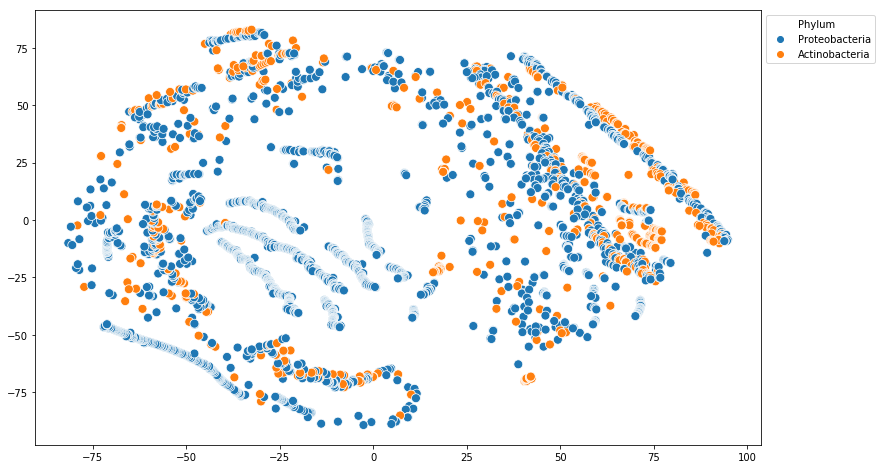

In [44]:
import seaborn as sns
plt.figure(figsize=(13,8))
no_bacteroid = [not i == "Bacteroidetes" for i in kpcof_plot.Phylum]
no_sr1  = [not i == "SR1" for i in kpcof_plot.Phylum]
no_eu  = [not i == "Euryarchaeota" for i in kpcof_plot.Phylum]

proteo = [i == "Proteobacteria" for i in kpcof_plot.Phylum]
bacter = [i == "Bacteroidetes" for i in kpcof_plot.Phylum]
firm = [i == "Firmicutes" for i in kpcof_plot.Phylum]
actino = [i == "Actinobacteria" for i in kpcof_plot.Phylum]
#no_clostridia = [not i == "Clostridia" for i in kpcof_plot.Class]
#keep = [i and j for i,j in zip(no_bacteroid, no_clostridia) ]
keep = [True for i in kpcof_plot.Phylum]
#keep = [i or j  for i,j in zip(proteo, actino)]

tsne_keep = tsne[keep, :]
kpcof_plot_keep = kpcof_plot.loc[keep, :]
#g = sns.scatterplot(tsne[keep,0], tsne[keep, 1], data = kpcof_plot.loc[keep, :], hue = "Phylum", s= 80)
j = 26000
g = sns.scatterplot(tsne_keep[0:j, 0], tsne_keep[0:j, 1], data = kpcof_plot_keep.iloc[0:j, :], hue = "Phylum", s= 80)
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [59]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
pca_trans = pca.fit_transform(qual_vecs.transpose())

In [93]:
print(qual_vecs.shape)
np.sum([i == j for i,j in zip(kpcof.index.values, qual_vecs.index.values)])

(26726, 100)


26726

In [101]:
#Color by pathway category
prop_pathway = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/pathways/property_pathway_dict.txt", sep = "\t")
plt.figure(figsize=(13,8))
sns.scatterplot(pca_trans[:, 0], pca_trans[:, 1], s = 200, data = prop_pathway, hue = "pathway_category")
plt.legend(bbox_to_anchor=(1, 1), loc=2)
#Problem is there is not just one pathway that correlates signficantly. A property is not a single pathway,
# it's a combination of pathways that dictates co-occurrence

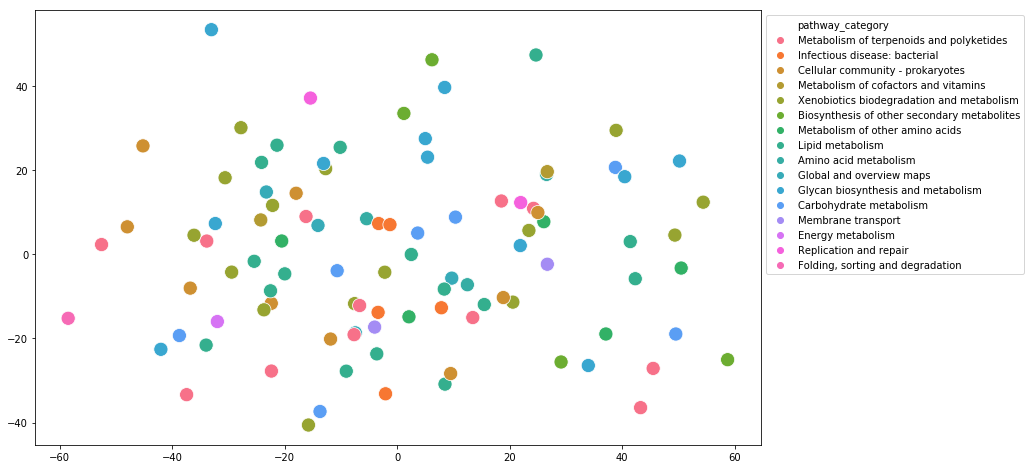

In [109]:
#Color by highest valued taxa
asv_def = qual_vecs.idxmax(axis = 0).values
kpcof_def = kpcof.loc[asv_def]
sns.scatterplot(pca_trans[:, 0], pca_trans[:, 1], s = 200, data = kpcof_def, hue = "Phylum")
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [131]:
pathway_cat = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/pathways/pathway_category.txt", 
                          sep = "\t", index_col = 1, header = None, dtype = str)
pathway_cat
pathway_associations = pd.read_csv("C:/Users/ctata/Documents/Lab/quality_vectors_final/data/pathways/property_pathway_dict_allsig.txt", sep = "\t")
pathway_cat.loc[pathway_associations.path_name, :]



c:\users\ctata\miniconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,property,path_id,path_name,corr_val
0,property_100_1,281,Citrate cycle (TCA cycle),0.198269
1,property_100_1,2030,Lysine degradation,0.193289
2,property_100_1,71,Histidine metabolism,0.191244
3,property_100_1,903,Phenylalanine metabolism,0.182869
4,property_100_1,592,Tryptophan metabolism,0.179675
5,property_100_1,410,beta-Alanine metabolism,0.178994
6,property_100_1,2040,Cyanoamino acid metabolism,0.176195
7,property_100_1,360,Glutathione metabolism,0.168418
8,property_100_1,361,Streptomycin biosynthesis,0.164479
9,property_100_1,623,Polyketide sugar unit biosynthesis,0.159531


In [133]:
np.unique(pathway_associations.property)

array(['property_100_1', 'property_100_2', 'property_100_3'], dtype=object)

In [142]:
#boxplot properties by their taxa categorizations

kpcof.loc[qual_vecs.index.values, "Phylum"]


Seq
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTA     Proteobacteria
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCAGTTGAGGCAGGCG      Bacteroidetes
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGACGCTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGGTGTCTTGAGTACAGTAGAGGCAGGCG      Bacteroidetes
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTGCTTTCAAAACTGTTTTTCTTGAGTAGTGCAGAGGTAGGCG         Firmicutes
TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATGTCTTGAGTGCAGTTGAGGCAGGCG      Bacteroidetes
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTA     Proteobacteria
AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGT